# Critical Collapse Study

Below is code to help study the formation of black holes. The equations integrated are described in the work by Bloomfield et. al.

arXiv paper: [1504.02071](https://arxiv.org/pdf/1504.02071.pdf)\
ar5iv version: [ar5iv](https://ar5iv.org/abs/1504.02071)

## Import Modules

In [104]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload 
import scipy.interpolate as interp
import scipy.constants as const

import cython
%load_ext Cython
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


## Import MS, HM modules

...and reload modules if needed

In [105]:
# importing MS and HM modules. Reload modules if needed
try :
    reload(ms_hm.MS)
    reload(ms_hm.HM)
except :
    pass

import ms_hm
from ms_hm.MS import *
from ms_hm.HM import *

## Various functions that use the MS and HM classes

Functions below compute various things using the Misner-Sharp or Hernandez-Misher classes.

In [106]:
%%cython

import cython
cimport numpy as np

cimport cython
ctypedef np.double_t DTYPE_t

from libc.math cimport exp
from libc.math cimport sqrt

from cython.parallel import prange

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef zero_crossing(np.ndarray x_in, double [::1] y):
    """
    Given an array of inputs y, find x where the function y(x) = 0
    """
    cdef int size = x_in.shape[0]
    cdef double [:] x = x_in
    cdef double w, zero=-1
    cdef int i
    
    for i in range(size-1): # loop through all y values
        if(y[i] * y[i+1] < 0): # if subsequent elements have opposite signs, a zero-crossing was found.
            # linearly extrapolate zero-crossing
            w = abs(y[i] / (y[i+1] - y[i])) 
            zero = x[i] * (1 - w) + x[i+1] * w
            break
            
    return zero

In [107]:
def mix_grid(left, right, n):
    """
    Function to generate coordinate spacings with a mix of uniform and logarithmic spacings,
    with uniform spacing at small values (0 to "left") then logarithmically spaced ("left" to "right").
    
    Returns an array of coordinate positions.
    """
    
    # Generate logarithmically spaced coordinates between "left" and "right"
    A = np.exp(np.linspace(left, right, n))
    dA = A[1] - A[0]
    
    # Generate uniformly spaced coordinates
    A = np.concatenate( (np.linspace(0, A[0], int(np.ceil(A[0] / dA)), endpoint=False), A))
    
    return A

def uni_grid( right, n):
    """
    Function to generate a uniformly-spaced array of coordinate positions
    
    Returns the array of uniformly spaced coordinates.
    """
    A = np.linspace(0, np.exp(right), n)
    return A

In [108]:
# Function to generate initial data for the MS class.
def gen_init(amp):
    delta0 = amp * np.exp(-Abar**2 / 2 /(1.6)**2)
    delta0P = amp * delta0 * 2 * (-1 / 2 / (1.6)**2 ) * Abar

    m = 1 + delta0 
    U = 1 - alpha * delta0 / 2
    R = 1 - alpha / 2 * (delta0 + w * Abar * delta0P / (1 + 3 * w) )
    return (R, m, U)

In [109]:
# Check if a BH forms
# The MS run should proceed until MS until it breaks. If 2m / R > 1, return true
def BH_form(amp):
    
    default_steps = 1500000
    
    (R, m, U) = gen_init(amp)
    ms = MS(R, m, U, w, alpha, A, rho0,
            trace_ray=False, BH_threshold=-1, plot_interval=default_steps)
    
    if (ms.adap_run_steps(default_steps) == -1):
        return (True, ms.delta)
    
    return (False, ms.delta)

In [110]:
def find_crit(lower, upper):
    """
    Binary search between lower and upper to find a critical amplitude
    (Note that this is NOT the critical density)
    return (critical, upper value)
    """    
    for i in range(20):
        mid = (lower + upper) / 2
        print('Iteration No ' + str(i))
        print('Trying with amplitude ' + str(mid))

        if(BH_form(mid)[0] == True):
            upper = mid
        else:
            lower = mid
    
    return ((upper + lower) / 2, upper)

In [111]:
def find_mass(amp, is_searching_for_crit=False):
    """
    Find mass of BHs for certain amplitude
    set is_searching_for_crit=True when searching for the critical point
    """
    print('Finding mass with amp ' + str(amp))
    
    default_steps = 1500000
    
    # Get initial conditions for run
    (R, m, U) = gen_init(amp)
    
    # Perform a MS run without raytracing
    ms = MS(R, m, U, w, alpha, A, rho0, trace_ray=False, BH_threshold=-1e1, plot_interval=default_steps)
    ms.adap_run_steps(default_steps)
    delta = ms.delta
    
    # Perform a run *with* raytracing to get ICs for an HM run
    ms = MS(R, m, U, w, alpha, A, rho0, trace_ray=True, BH_threshold=-1e1, plot_interval=default_steps)
    flag = ms.run_steps(default_steps)
    if(flag != 0):
        raise ValueError('Not finishing ray-tracing with the amplitude ' + str(amp))
        
    # Perform an HM run
    hm = HM(ms, mOverR=0.99, sm_sigma=50)
    bh_formed = hm.adap_run_steps(550000) == 1
    if(not bh_formed and is_searching_for_crit==False):
        raise ValueError('Cannot get the target 2m/R with the amplitude ' + str(amp))
    
    print(ms.delta, hm.BH_mass2())
    return (ms.delta, hm.BH_mass2())

In [112]:
# Generate critical scaling data 
def critical_scaling(crit_amp, lower_amp, upper_amp, n=10):
    amps = 10**np.linspace(np.log10(lower_amp - crit_amp), np.log10(upper_amp - crit_amp), n) + crit_amp
    print(amps)
    masses = np.array([find_mass(amp) for amp in amps])
    crit_delta = find_mass(crit_amp, is_searching_for_crit=True)[0]
    
    return (masses, crit_delta)

## Equation of State Setup 

Code below will generate the (interpolated) QCD equation of state

<ipython-input-114-7d5cb7c9c550>:37: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.loglog(x, y, 'ko', label='Tabulated Values')


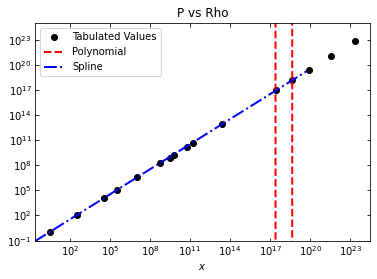

In [114]:
%matplotlib inline

# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

#Useful arrays
T = np.array([1,3.1623,10,17.783,39.811,100,141.254,158.489,251.189,316.228,1000,10000,19952.623,39810.717,100000,281838.293])
geff = np.array([10.71,10.74,10.76,11.09,13.68,17.61,24.07,29.84,47.83,53.04,73.48,83.10,85.56,91.97,102.17,104.98])
rho = (np.pi**2 / 30)* np.multiply(geff,T**4)
FoUrHoVeR3g = np.multiply(4/3,np.reciprocal(np.array([1.00228,1.00029,1.00048,1.00505,1.02159,1.02324,1.05423,1.07578,1.06118,1.04690,1.01778,1.00123,1.00589,1.00887,1.00750,1.00023]))
)
P=np.multiply(FoUrHoVeR3g,rho)-rho

N = 16 # Number of points to generate
xmax = 5e+19
xmin = 0
x = rho
y = P

# Use polynomial interpolation and a spline
ypoly = interp.lagrange(x,y)
yspline = interp.InterpolatedUnivariateSpline(x,y)

# For plotting purpose we generate a fine grid
xx = np.linspace(xmin, xmax, 1000)
ytrue = x

# Now make a plot
#plt.autoscale(enable=True, axis='y')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axhline(0, color='k')
ax.loglog(x, y, 'ko', label='Tabulated Values')
ax.loglog(xx, ypoly(xx), 'r--', lw=2, label='Polynomial')
ax.loglog(xx, yspline(xx), 'b-.', lw=2, label='Spline')
# ax.set_xlim(xx[0], xx[-1])
ax.set_ylim(.1, 1e+25)
ax.legend(loc='best')
ax.set_xlabel(r'$x$')
ax.set_title('P vs Rho');

<ipython-input-102-b1d65d5f2225>:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.loglog(x, -y + x / 3, 'ko', label='Tabulated Values')


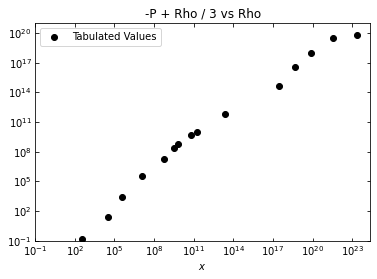

In [102]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axhline(0, color='k')
ax.loglog(x, -y + x / 3, 'ko', label='Tabulated Values')
# ax.semilogy(xx, ypoly(xx) - xx / 3, 'r--', lw=2, label='Polynomial')
# ax.semilogy(xx, yspline(xx) - xx / 3, 'b-.', lw=2, label='Spline')
#ax.set_xlim(xx[0], xx[-1])
ax.set_xlim(.1,2.2e+24)
ax.set_ylim(.1, 1e+21)
ax.legend(loc='best')
ax.set_xlabel(r'$x$')
ax.set_title('-P + Rho / 3 vs Rho');

In [118]:
print(rho)

[3.52344877e+00 3.53341822e+02 3.53989811e+04 3.64863274e+05
 1.13051658e+07 5.79345778e+08 3.15251819e+09 6.19403721e+09
 6.26442681e+10 1.74495122e+11 2.41739510e+13 2.73388042e+17
 4.46117494e+18 7.60019394e+19 3.36125827e+21 2.17913963e+23]


## Simulation setup

Code below will set up grids (arrays) for running the simulations.

In [119]:
# some general set-up

# simulation resolution parameter
n = 3000

# Generate an array of coordinate positions for the simulation to run at
lower = -0.5 # The coordinates will be linearly spaced from 0 to e^lower
upper = 2.0 # The coordinates will be log spaced from e^lower to e^upper
A = mix_grid(lower,upper,n)

w = FoUrHoVeR3g + np.array([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]) # equation of state parameter
alpha = (2 / 3) * (1+w) # Parameter appearing in exponent describing the expansion rate (not the lapse)

rho0 = 3 # initial density value in Hubble units
t0 = alpha * np.sqrt(3 / (8*np.pi*rho0)) # initial simulation time in Hubble units
RH = t0 / alpha # Hubble horizon radius

Abar = A / RH # Re-scaled coordinates

ValueError: operands could not be broadcast together with shapes (4200,) (16,) 

## Scratch Work

Below is some scratch work useful for testing simulations and getting things set up to run

Not Tracing ray and NO excision will be performed!


ValueError: Large psi detected at step 12936!

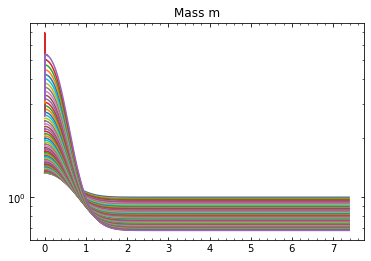

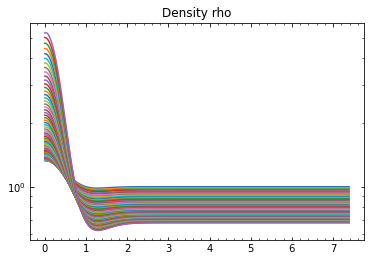

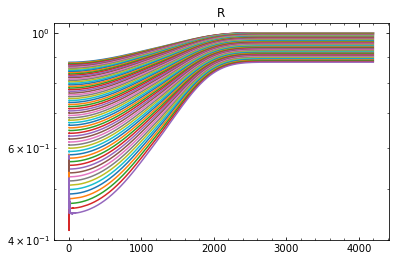

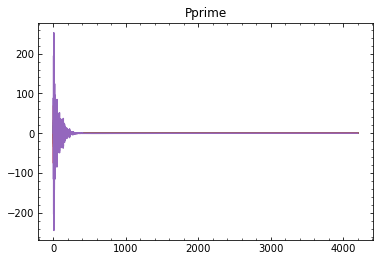

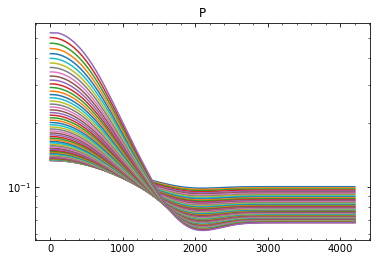

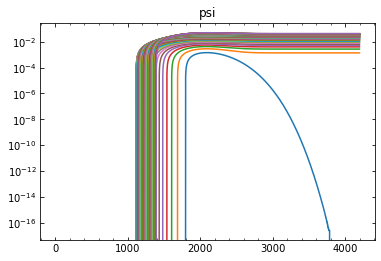

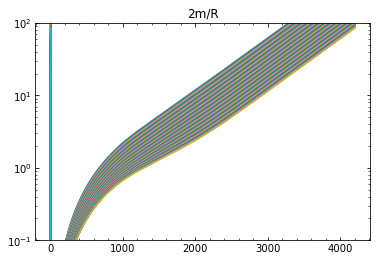

In [11]:
# Reload MS module and try a run
reload(ms_hm.MS)
from ms_hm.MS import *
amp = 0.335
(R, m, U) = gen_init(amp)
ms = MS(R, m, U, w, alpha, A, rho0,
        trace_ray=False, BH_threshold=-1, sm_sigma=60, plot_interval=200)
ms.run_steps(4000000)

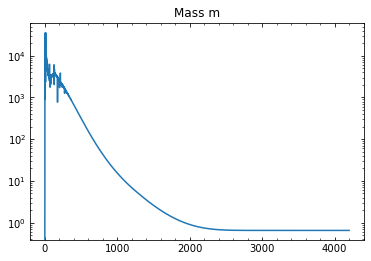

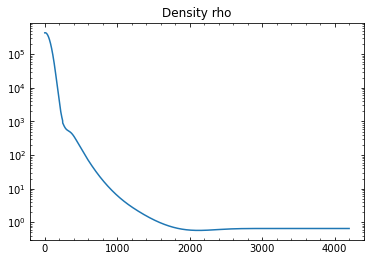

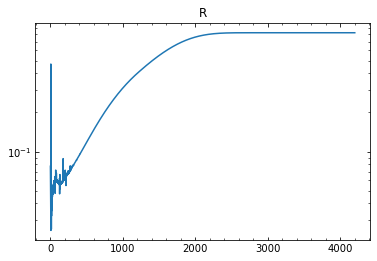

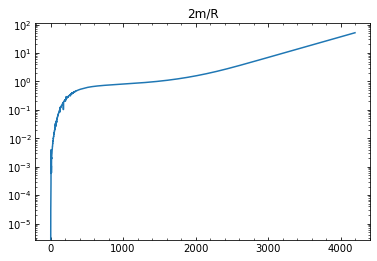

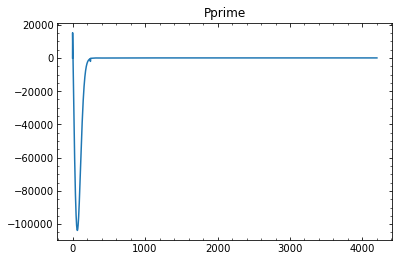

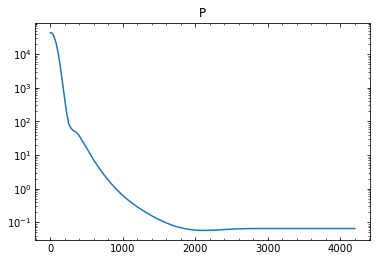

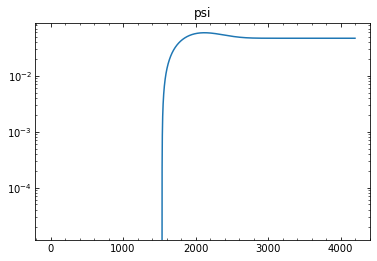

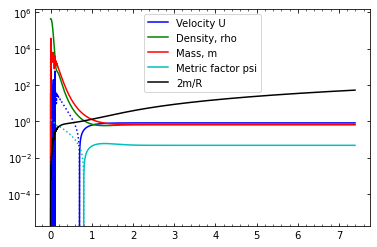

In [428]:
ms.plot_fields(force_plot=True)

In [ ]:
reload(ms_hm.HM)
from ms_hm.HM import *
hm = HM(ms, mOverR=0.99, sm_sigma=15)
hm.adap_run_steps(550000)
print(hm.BH_mass2())

In [ ]:
find_mass(0.30, is_searching_for_crit=False)

In [ ]:
# Call the find_crit function to search for the amplitude required to form a BH
find_crit(0.27, 0.30)

Finding mass with amp 0.29957632221281527
Not Tracing ray and NO excision will be performed!
Warning, the time step is too small!
Tracing ray is enabled and excision will be performed!
Photon has gone out of the outter boundary!
2m/R is larger than 0.99
0.4812869164555946 60.53504515280334


(0.4812869164555946, 60.53504515280334)

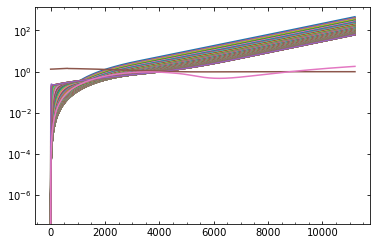

In [171]:
find_mass(0.29957632221281527, is_searching_for_crit=False)

In [14]:
find_mass(0.2728846216201781, is_searching_for_crit=True)

Finding mass with amp 0.2728846216201781
Not Tracing ray and NO excision will be performed!
Warning, the time step is too small!
Tracing ray is enabled and excision will be performed!
Photon has gone out of the outter boundary!
Warning, the time step is too small!
0.42650921473655545 0.46829034947396747


(0.42650921473655545, 0.46829034947396747)

## Simulation Run

Below is an example of all the code needed to find the critical scaling threshhold and exponent.

In [ ]:
# Find the critical point. It will be bounded between crit and lower.
(crit, lower) = find_crit()
# Find the mass of BHs at various amplitudes between lower_amp and lower_amp plus a bit.
res = critical_scaling(crit, lower_amp, lower_amp + 1e-2, 20)

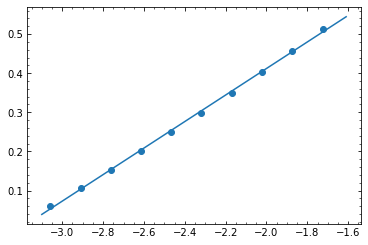

In [127]:
(a, b ) = np.polyfit(np.log10(res2[0][:,0] - res2[1])[:], np.log10(res2[0][:,1])[:], deg=1)
plt.scatter(np.log10(res2[0][:,0] - res2[1])[:], np.log10(res2[0][:,1])[:])
plt.plot(np.arange(-3.1,-1.6,0.01), a * np.arange(-3.1,-1.6,0.01) + b)

In [106]:
np.polyfit(np.log10(res[0][:,0] - 0.4265539636281781)[:], np.log10(res[0][:,1])[:], deg=1)

array([0.30727515, 1.00595765])